In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sklearn.base as skb
import sklearn.model_selection as skms
import sklearn.neighbors as skn
import sklearn.pipeline as  skpi
import sklearn.preprocessing as skpr

In [3]:
# Helper functions for getting and plotting data

class DataGetter:
    def __init__(self):
        self.temp_data = netCDF4.Dataset("data/erai_t2m_daily.nc")
        self.precip_data = netCDF4.Dataset("data/erai_tp_daily.nc")
        
    def retrieve_fine_data(self, dataset='temp', t=0, region=None):
        if dataset in ('temp', 'temperature', 't2m'):
            data = self.temp_data
            data_name = 't2m'
        elif dataset in ('precip', 'precipitation', 'tp'):
            data = self.precip_data
            data_name = 'tp'
        else:
            raise Exception('Unknown dataset {}'.format(dataset))
            
        return_data = np.array(data.variables[data_name][t, ::-1, :])
        if region is None:
            return return_data
        else:
            xmin, xmax, ymin, ymax = region
            return return_data[ymin:ymax, xmin:xmax]

    @staticmethod
    def coarsen(f_data, sep=2):
        return f_data[::sep, ::sep]


class Plotter:
    @staticmethod
    def plot_data(data, region=None, cmap=plt.get_cmap('jet')):
        plt.pcolormesh(data, cmap=cmap)
        plt.colorbar()
        if region is not None:
            xmin, xmax, ymin, ymax = region
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        plt.show()
        
    @classmethod
    def plot_diff(cls, p_data, f_data, region=None, cmap=plt.get_cmap('jet')):
        cls.plot_data(p_data - f_data, region, cmap=cmap)


def rms(p_data, f_data):
    return np.sqrt(np.sum((p_data - f_data) ** 2))

In [4]:
# Helper functions for preprocessing the data

class _BaseTransformer(skb.TransformerMixin, skb.BaseEstimator):
    def fit(self, X, y=None):
            return self

class Reshaper(_BaseTransformer):            
    def transform(self, X, y=None):
            return np.array([x.reshape(-1) for x in X])
        
    def inverse_transform(self, X, y=None):
        return np.array([x.reshape(256, 512) for x in X])  # Hardcoded for now
     
    
class Binner(_BaseTransformer):
    def transform(self, X, y=None):
            return np.array([[np.int(100 * y) for y in x]  for x in X])
        
    def inverse_transform(self, X, y=None):
        return np.array([[y/100 for y in x] for x in X])
    
pipe = skpi.Pipeline([('reshaper', Reshaper()),
                      ('minmax_scaler', skpr.MinMaxScaler()),
                      ('binner', Binner()),
                     ])

In [12]:
# Sample region for zooming in on
xmin, xmax, ymin, ymax = region = (430, 490, 210, 240)

# tp or t2m for precipitation/temperature respectively
dataset = 't2m'
# We keep one in sep^2 pieces of data
sep = 10
# What proportion of the data to set aside for testing the machine
test_size = 0.2
# How many pieces of data we use
timerange = 100

# Unprepared fine and coarse data
fine_data = []
coarse_data = []

data_getter = DataGetter()

for timestamp in range(timerange):
    f_data = data_getter.retrieve_fine_data(dataset, timestamp)
    c_data = data_getter.coarsen(f_data, sep)
    fine_data.append(f_data)
    coarse_data.append(c_data)
    
# The shape of the fine and predicted data
f_shape = fine_data[0].shape
    
# Unprepared fine and coarse data, split into training and testing
unprep_train_coarse, unprep_test_coarse, unprep_train_fine, unprep_test_fine = skms.train_test_split(coarse_data, fine_data, test_size=test_size, random_state=42)

In [13]:
# Prepared fine and coarse data. May take a short amount of time.
train_coarse = pipe.fit_transform(unprep_train_coarse)
test_coarse = pipe.fit_transform(unprep_test_coarse)
train_fine = pipe.fit_transform(unprep_train_fine)
test_fine = pipe.fit_transform(unprep_test_fine)

In [14]:
# Tests a given machine on a particular piece of data

def test_ml(ml, index, prepared=True, inp='test'):
    if inp == 'train':
        u_f_data = unprep_train_fine[index]
        u_c_data = unprep_train_coarse[index]
        c_data = train_coarse[index]
    elif inp == 'test':
        u_f_data = unprep_test_fine[index]
        u_c_data = unprep_test_coarse[index]
        c_data = test_coarse[index]
    else:
        raise Exception
        
    if not prepared:
        c_data = u_c_data
        
    p_data = ml.predict([c_data])
    
    if prepared:
        u_p_data = pipe.inverse_transform(p_data)[0]
    else:
        u_p_data = p_data[0]
        
    print("Input:")
    Plotter.plot_data(u_c_data)
    print("Prediction:")
    Plotter.plot_data(u_p_data)
    print("Actualiy:")
    Plotter.plot_data(u_f_data)
    print("Prediction - Actuality:")
    Plotter.plot_diff(u_p_data, u_f_data)
    print("RMS: ", rms(u_p_data, u_f_data))

In [15]:
# Basic local linear interpolation 'machine learning'
# Note that it uses *unprepared* training data.

class Interpolator:
    def __init__(self, f_shape, sep):
        self._f_shape = f_shape
        self._sep = sep
    
    @staticmethod
    def local_interpolater(interpolate_func):
        def local_interpolater_inner(self, c_data):
            return_data = np.empty(self._f_shape, dtype=np.float32)
            for y in range(self._f_shape[0]):
                for x in range(self._f_shape[1]):
                    return_data[y, x] = interpolate_func(x, y, c_data)
            return return_data
        return local_interpolater_inner

#     def _zero_func(self, x, y, c_data):
#         if y % sep == 0 and x % sep == 0:  # Known data
#             return c_data[y // sep, x // sep]
#         else:
#             return 0

#     separate_data = local_interpolater.__func__(_zero_func)

    def _mean_func(self, x, y, c_data):
        c_shape = c_data.shape
        prop_x = (x % self._sep) / self._sep
        prop_y = (y % self._sep) / self._sep
        
        # We take modulo on the x direction because that correspons to going around the world;
        # it makes sense to use data from the other side.
        # For the y axis, we apply a minimum to limit things to use the best data we have when we get to the edge of the data
        return (
                (1 - prop_x) * (1 - prop_y) * c_data[y // self._sep, x // self._sep] + 
                prop_x       * (1 - prop_y) * c_data[y // self._sep, (1 + x // self._sep) % c_shape[1]] +        
                (1 - prop_x) * prop_y       * c_data[min(c_shape[0] - 1, 1 + y // self._sep), x // self._sep] +
                prop_x       * prop_y       * c_data[min(c_shape[0] - 1, 1 + y // self._sep), (1 + x // self._sep) % c_shape[1]]
               )
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, Xs):
        averager = self.local_interpolater(self._mean_func)
        return [averager(self, X) for X in Xs]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
knn_clf = RandomForestRegressor()
knn_clf.fit(train_coarse, train_fine);

Input:


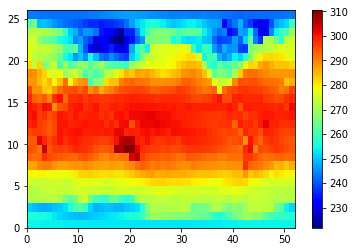

Prediction:


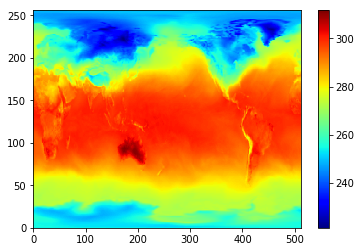

Actualiy:


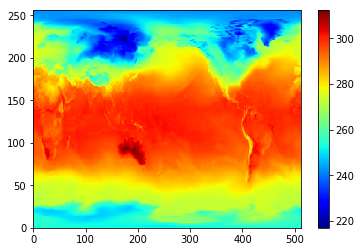

Prediction - Actuality:


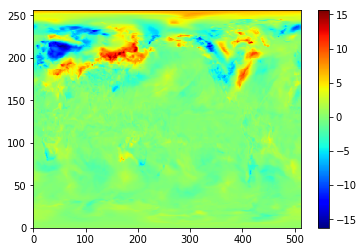

RMS:  852.8765288293869


In [11]:
test_ml(knn_clf, 0)